# REMDのOpenMM実装
- ChatGPTを使用

In [1]:
from openmm.app import *
from openmm import *
from openmm.unit import *
import numpy as np
from tqdm.notebook import tqdm
import random

In [68]:
# 入力ファイルの準備
pdb = app.PDBFile('/data2/yingh/openmm-tutorial-msbs/02_alanine_dipeptide/alanine-dipeptide.pdb')
forcefield = app.ForceField('amber99sbildn.xml', 'tip3p.xml')

# add solvent
modeller = Modeller(pdb.topology, pdb.positions)
print('Adding solvent...')
modeller.addSolvent(forcefield, model='tip3p', padding=1*nanometer)
PDBFile.writeFile(modeller.topology, modeller.positions, open('ala2_solvated.pdb', 'w'))

Adding solvent...


In [72]:
pdb = app.PDBFile('./ala2_solvated.pdb')
forcefield = app.ForceField('amber99sbildn.xml', 'tip3p.xml')

# パラメータ設定
num_replicas = 8  # レプリカ数
temperature_min = 300 # K
temperature_max = 500 # K
temperatures = np.linspace(temperature_min, temperature_max, num_replicas)  # 温度 (Kelvin)
print('Temperatures (K):', temperatures)

n_steps = 100000 # シミュレーション総ステップ数
n_steps_exchange = 1000 # 交換を試みる間隔 (steps)
n_steps_save = 100
n_steps_equil = 20000



system = forcefield.createSystem(
    pdb.topology,
    nonbondedMethod=app.PME,
    nonbondedCutoff=1.0*nanometer,
    constraints=app.HBonds,
)
print('System created...')

# レプリカごとに異なるシミュレーションをセットアップ
integrators = []
simulations = []
for i, temp in enumerate(temperatures):
    integrator = LangevinIntegrator(
        temp*kelvin,       # 温度
        1.0/picosecond,    # 摩擦係数
        0.002*picoseconds  # タイムステップ
    )
    integrators.append(integrator)
    simulation = app.Simulation(pdb.topology, system, integrator)
    simulation.context.setPositions(pdb.positions)
    simulation.context.setVelocitiesToTemperature(temp*kelvin)
    simulations.append(simulation)

# エネルギー交換関数
def attempt_exchange(replica1, replica2):
    E1 = simulations[replica1].context.getState(getEnergy=True).getPotentialEnergy()
    E2 = simulations[replica2].context.getState(getEnergy=True).getPotentialEnergy()
    beta1 = 1 / (BOLTZMANN_CONSTANT_kB * temperatures[replica1] * kelvin)
    beta2 = 1 / (BOLTZMANN_CONSTANT_kB * temperatures[replica2] * kelvin)
    delta = (beta2 - beta1) * (E1 - E2) / AVOGADRO_CONSTANT_NA
    # print(delta)
    if delta < 0 or random.uniform(0, 1) < np.exp(-delta):
        # 交換を行う
        # print(f"Exchange accepted between replica {replica1} and {replica2}")
        temp1 = temperatures[replica1]
        # temperatures[replica1] = temperatures[replica2]
        # temperatures[replica2] = temp1
        positions1 = simulations[replica1].context.getState(getPositions=True).getPositions()
        positions2 = simulations[replica2].context.getState(getPositions=True).getPositions()
        simulations[replica1].context.setPositions(positions2)
        simulations[replica2].context.setPositions(positions1)
    else:
        # print(f"Exchange rejected between replica {replica1} and {replica2}")
        pass

# equilibrium
print('Equilibration...')
sim.step(n_steps_equil)


# append reporters
print('Addint Reporters...')
dcd_reporters = [app.DCDReporter(file=f'replica_{i}.dcd', reportInterval=n_steps_save) for i, temp in enumerate(temperatures)]
state_data_reporters = [app.StateDataReporter(file=f'replica_{i}.log', reportInterval=n_steps_save, step=True, temperature=True) for i, temp in enumerate(temperatures)]

for i, temp in enumerate(temperatures):
    simulations[i].reporters.append(dcd_reporters[i])
    simulations[i].reporters.append(state_data_reporters[i])

# シミュレーションループ
print('Production...')
for step in tqdm(range(0, n_steps, n_steps_exchange), leave=False):
    # print(f'*** Step {step} ***"')
    for sim in simulations:
        sim.step(n_steps_exchange)  # 各レプリカで実行

    # レプリカ間での交換試行
    for i in range(num_replicas - 1):
        attempt_exchange(i, i + 1)

# シミュレーション結果を保存
for i, sim in enumerate(simulations):
    state = sim.context.getState(getPositions=True, getEnergy=True)
    with open(f"output_replica_{i}.pdb", "w") as f:
        app.PDBFile.writeFile(pdb.topology, state.getPositions(), f)


Temperatures (K): [300.         328.57142857 357.14285714 385.71428571 414.28571429
 442.85714286 471.42857143 500.        ]
System created...
Equilibration...
Addint Reporters...
Production...


  0%|          | 0/100 [00:00<?, ?it/s]

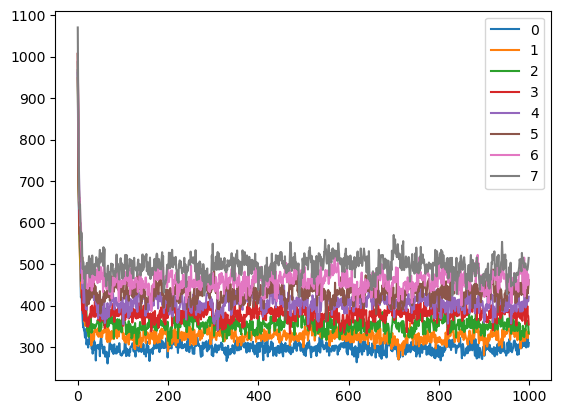

In [73]:
import pandas
import matplotlib.pyplot as plt
for i, temp in enumerate(temperatures):
    df1 = pandas.read_csv(f"replica_{i}.log")
    plt.plot(df1['Temperature (K)'], label=f'{i}')
plt.legend()
plt.show()